In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow_probability.substrates import numpy as tfp
from cmdstanpy import CmdStanModel, set_cmdstan_path
import arviz as az

c:\Users\matte\anaconda3\envs\stan\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
X = pd.read_csv("../Datasets/covariates.csv")
Y = pd.read_csv("../Datasets/Dataset_120.csv")
Y.loc[:,'Count_120'] = pd.to_numeric(Y['Count_120']).astype('Int64')
X = pd.get_dummies(X ,columns = ['Type'] ,prefix = 'type', drop_first = True)
X.loc[X['Station'] == 10171, 'Quota'] = 10

In [5]:
rows_to_drop_Y = Y[Y['Count_120'].isna()].index

# Remove corresponding rows from dataset X
X = X.drop(index=rows_to_drop_Y)
Y = Y.drop(index=rows_to_drop_Y)

# If you want to reset the index after dropping rows
X = X.reset_index(drop=True)
Y = Y.reset_index(drop=True)

In [6]:
stations = X['Station']
years = X['Year'] - 2009
unique_values = sorted(set(stations))
mapping_dict = {value: index + 1 for index, value in enumerate(unique_values)}
transformed_stations = [mapping_dict[value] for value in stations]

In [7]:
base_model = """

data {
  int<lower=1> N; // Number of observations
  int<lower=1> P; // Covariate number
  int<lower=1> nyears;
  int<lower=1> nstations;


  array[N] int<lower=1> station;
  array[N] int<lower=1> year;
  // array[N] int<lower=4, upper=10> month;

  array[N] int<lower=0> y; // Count data
  matrix[N, P] X; // Predictor matrix
}

parameters {
  vector[P] beta; // Coefficients for predictors
  vector[nstations] eta; // Random effects for comuni
  vector[nyears] xi; // Random effects for years

  //real<lower=0> sigma0; // Standard deviation for beta
  //real<lower=0> sigma1; // Standard deviation for xi
  //real<lower=0> sigma2; // Standard deviation for eta
}

transformed parameters {
    vector[N] lambda;
    vector[N] intercept;
    vector[N] fix_eff;

    intercept = xi[year] + eta[station];
    fix_eff = X * beta;

    lambda = exp(intercept + fix_eff);
    //lambda = exp(fix_eff);
}

model {

  beta ~ normal(0, 2);
  xi ~ normal(0, 2);
  eta ~ normal(0, 2);
  y[1:N] ~ poisson(lambda[1:N]);


}
generated quantities{
 vector[N] log_lik;
 for(i in 1:N){
   log_lik [ i ] = poisson_lpmf (y [ i ] |lambda[i]) ;
  }
  
}

"""

stan_file = "./base.stan"

with open(stan_file, "w") as f:
    print(base_model, file=f)

model_base = CmdStanModel(stan_file=stan_file)

10:16:58 - cmdstanpy - INFO - compiling stan file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\base.stan to exe file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\base.exe


10:19:34 - cmdstanpy - INFO - compiled model executable: C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\base.exe


In [8]:
X = X.drop(['Year','Station','Month'], axis  = 1)

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_std = pd.DataFrame(X_std, columns=X.columns)
X_std.loc[:,"type_rural"] = X.loc[:,"type_rural"]
X_std.loc[:,"type_urban"] = X.loc[:,"type_urban"]
X_std.loc[:,"type_rural"] = pd.to_numeric(X_std.loc[:,"type_rural"]).astype('Int64')
X_std.loc[:,"type_urban"] = pd.to_numeric(X_std.loc[:,"type_urban"]).astype('Int64')
X_std.head()

mean_temperature  mean_precipitation_sum  mean_precipitation_hours  \
0         -1.427024               -0.608034                 -0.028251   
1         -0.676275                2.540869                  2.016045   
2          0.428463               -0.188775                  0.329701   
3          1.453029               -1.003430                 -0.981119   
4          0.529757                1.317785                  0.374383   

   mean_windspeed_10m_max  mean_radiation_sum  count_highwind  \
0                0.226227           -0.005763        0.064719   
1                0.514356            0.171209        0.590376   
2               -0.115611            0.813638       -0.101560   
3                0.160412            1.249078        0.027172   
4                0.023923           -0.016637        0.268545   

   max_consecutive_highwind_days   Densità     Quota  type_rural  type_urban  
0                      -0.210751 -0.316079 -0.119963           0           1  
1                       0.589728 -0.316079 -0.119963           0           1  
2                      -0.210751 -0.316079 -0.119963           0           1  
3                       0.589728 -0.316079 -0.119963           0           1  
4                       0.589728 -0.316079 -0.119963           0           1

In [10]:
data = {
    "N": len(Y),
    "P": X_std.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": transformed_stations,
    "year": years,
    "y": Y['Count_120'],
    "X": X_std
}


fit = model_base.sample(data=data, chains=4, parallel_chains=4, 
    iter_warmup=300, iter_sampling=200)
posterior_az = az.from_cmdstanpy(fit)

10:19:36 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█▍        | 00:00 Status


chain 1 |██▊       | 00:35 Iteration:   1 / 500 [  0%]  (Warmup)


chain 1 |████▎     | 04:02 Iteration: 100 / 500 [ 20%]  (Warmup)



chain 1 |███████▏  | 05:39 Iteration: 300 / 500 [ 60%]  (Warmup)




chain 1 |████████▌ | 07:10 Iteration: 301 / 500 [ 60%]  (Sampling)
chain 1 |██████████| 08:28 Sampling completed                     
chain 2 |██████████| 08:28 Sampling completed                     
chain 3 |██████████| 08:28 Sampling completed                     
chain 4 |██████████| 08:28 Sampling completed                     


10:28:04 - cmdstanpy - INFO - CmdStan done processing.


10:28:09 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 42 iterations at max treedepth (21.0%)
	Chain 2 had 64 iterations at max treedepth (32.0%)
	Chain 3 had 47 iterations at max treedepth (23.5%)
	Chain 4 had 30 iterations at max treedepth (15.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


In [11]:
fit.summary()

Mean      MCSE    StdDev            5%           50%  \
lp__           56368.500000  0.424416  5.643180  56358.300000  56368.800000   
beta[1]            0.512465  0.000625  0.010921      0.494570      0.512770   
beta[2]            0.053483  0.000762  0.010302      0.036426      0.053727   
beta[3]           -0.127543  0.001100  0.015347     -0.154715     -0.127325   
beta[4]           -0.301054  0.001997  0.041331     -0.364139     -0.303077   
...                     ...       ...       ...           ...           ...   
log_lik[3836]     -2.699900  0.005076  0.148682     -2.967490     -2.689440   
log_lik[3837]     -2.760610  0.003996  0.120817     -2.982800     -2.738700   
log_lik[3838]     -5.107260  0.010682  0.334799     -5.668100     -5.095510   
log_lik[3839]     -1.532790  0.000713  0.020163     -1.571030     -1.529590   
log_lik[3840]     -1.820430  0.003073  0.086391     -1.967820     -1.818770   

                        95%    N_Eff   N_Eff/s     R_hat  
lp__           56377.000000  176.793  0.244595  1.000780  
beta[1]            0.530937  305.594  0.422793  1.029440  
beta[2]            0.070871  182.900  0.253044  1.049780  
beta[3]           -0.104073  194.626  0.269267  1.035490  
beta[4]           -0.232343  428.396  0.592691  1.010180  
...                     ...      ...       ...       ...  
log_lik[3836]     -2.494820  857.970  1.187010  0.996617  
log_lik[3837]     -2.609600  914.052  1.264600  0.996638  
log_lik[3838]     -4.591710  982.328  1.359060  0.995912  
log_lik[3839]     -1.504960  800.125  1.106980  0.996972  
log_lik[3840]     -1.677620  790.111  1.093130  0.997737  

[15430 rows x 9 columns]

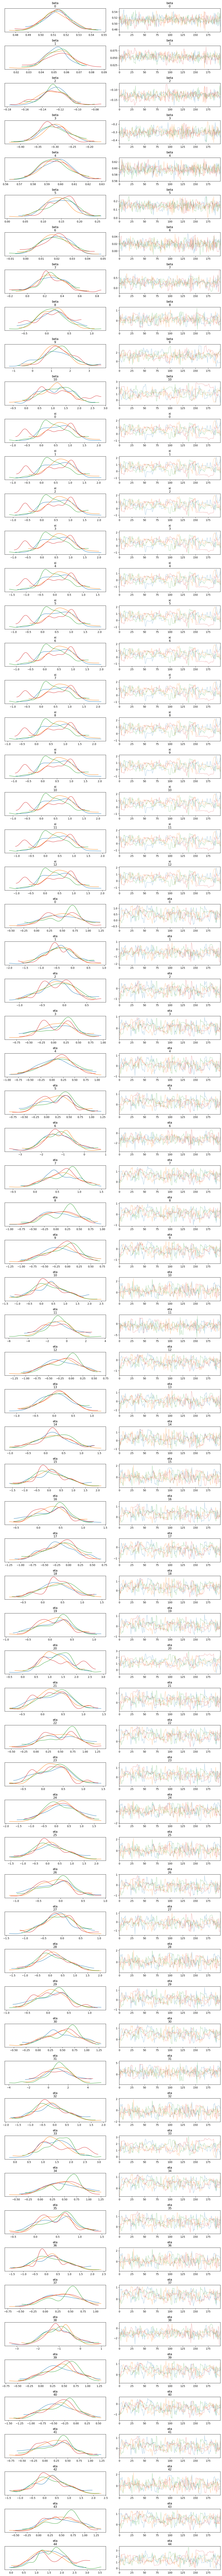

In [12]:
az.rcParams['plot.max_subplots'] = 200
az.plot_trace(posterior_az, var_names=['beta', 'xi', 'eta'], compact=False)
plt.tight_layout()
plt.show()

In [13]:
posterior_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

In [14]:
lam = posterior_az['posterior']['lambda']
lam

<xarray.DataArray 'lambda' (chain: 4, draw: 200, lambda_dim_0: 3840)>
array([[[ 3.22496,  4.80356, 14.3623 , ..., 13.9547 ,  3.35872,
          1.76452],
        [ 3.35864,  5.03806, 14.9771 , ..., 15.1781 ,  3.64818,
          1.95716],
        [ 3.26446,  4.86656, 14.7462 , ..., 14.5887 ,  3.43547,
          1.81126],
        ...,
        [ 3.07685,  4.69453, 13.9127 , ..., 15.4688 ,  3.62017,
          1.91013],
        [ 3.07203,  4.69709, 13.6898 , ..., 14.6256 ,  3.47505,
          1.79802],
        [ 3.3487 ,  4.94691, 14.6131 , ..., 15.2211 ,  3.66034,
          1.93583]],

       [[ 3.57687,  5.39019, 15.766  , ..., 14.0633 ,  3.41401,
          1.74566],
        [ 3.47948,  5.22958, 15.7479 , ..., 14.2053 ,  3.37513,
          1.79253],
        [ 3.18444,  4.89829, 14.1915 , ..., 14.6565 ,  3.50016,
          1.78152],
...
        [ 3.42779,  5.12153, 15.2075 , ..., 14.2431 ,  3.41972,
          1.79996],
        [ 3.36303,  5.22251, 15.6911 , ..., 14.9764 ,  3.53171,
          1.74055],
        [ 3.48413,  5.1865 , 15.434  , ..., 14.1506 ,  3.38911,
          1.75449]],

       [[ 3.34095,  5.08698, 15.1829 , ..., 15.0243 ,  3.58562,
          1.81877],
        [ 3.28386,  5.08236, 14.8396 , ..., 15.0331 ,  3.63481,
          1.86649],
        [ 3.33243,  5.08971, 14.9351 , ..., 15.0269 ,  3.60329,
          1.88827],
        ...,
        [ 3.44017,  4.88382, 14.9718 , ..., 14.8053 ,  3.53289,
          1.93628],
        [ 3.34267,  4.81595, 14.6402 , ..., 14.5052 ,  3.46552,
          1.91118],
        [ 3.22125,  4.63618, 14.102  , ..., 14.6986 ,  3.50949,
          1.92647]]])
Coordinates:
  * chain         (chain) int32 0 1 2 3
  * draw          (draw) int32 0 1 2 3 4 5 6 7 ... 193 194 195 196 197 198 199
  * lambda_dim_0  (lambda_dim_0) int32 0 1 2 3 4 5 ... 3835 3836 3837 3838 3839

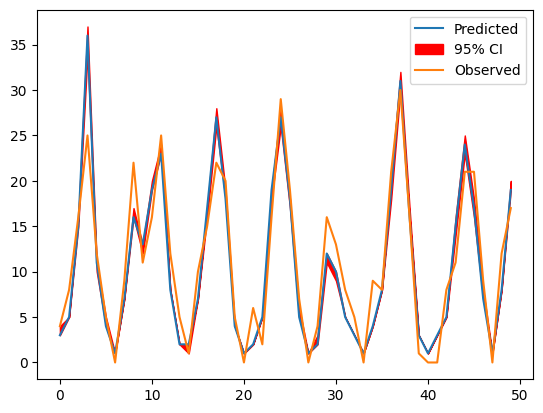

In [15]:
# Generating posterior predictive distribution confidence intervals
preds = np.round(lam.mean(axis=0).mean(axis=0))
lower = np.round(np.percentile(lam, 2.5, axis=0).mean(axis=0))
upper = np.round(np.percentile(lam, 97.5, axis=0).mean(axis=0))
x = np.arange(0, 50)
plt.plot(x, preds[x], label="Predicted")
plt.fill_between(x, lower[x], upper[x], alpha=1, label="95% CI", color='red')
plt.plot(x, Y.loc[x, 'Count_120'], label="Observed")
plt.legend()
plt.show()

In [ ]:
eta = posterior_az['posterior']['eta']
eta
len(np.unique(stations))

45

In [ ]:
inference = []
for i in range(len(np.unique(stations))):
    ar1 = eta[0, :, i]
    ar2 = eta[1, :, i]
    ar3 = eta[2, :, i]
    ar4 = eta[3, :, i]
    current_iteration_df = np.concatenate((ar1, ar2, ar3, ar4), axis=0)
    inference.append(current_iteration_df)

len(current_iteration_df)
len(inference)

45

In [ ]:
df = pd.DataFrame(inference).transpose()
df.shape
df.columns = np.unique(stations)
df.columns.values

array([ 5707,  5710,  5717,  5718,  5719,  5721,  5725,  5730,  5732,
        5735,  5738,  5739,  5742,  5749,  5750,  5952,  5960,  6582,
        6665,  6691,  6804,  6818,  6832,  6884,  6904,  9856,  9861,
        9882,  9899,  9925,  9972,  9991,  9997, 10025, 10041, 10081,
       10171, 10270, 10282, 10288, 10437, 10454, 10463, 10584, 12020],
      dtype=int64)

In [ ]:
csv_path = '../Datasets/eta_120.csv'
data = pd.DataFrame(df)
# Save the DataFrame to a CSV file
data.to_csv(csv_path, index=False)